# DLAI Project
Lossy Text Compressor

By Swati Aggrawal

2118031

Importing Required Libraries

In [ ]:
!pip install vec2text

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.6/433.6 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.6/220.6 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.5 MB/s eta 0:00:00
   ━

In [ ]:
!pip install rouge

In [ ]:
import vec2text
import torch
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Defining Functions for Embedding Extraction and Quantization

In [ ]:
# Function to obtain embeddings using a GTR
def get_gtr_embeddings(text_list, encoder, tokenizer):
    # Tokenize the input text and prepare it for the encoder
    inputs = tokenizer(
        text_list,
        return_tensors="pt",
        max_length=128,
        truncation=True,
        padding="max_length"
    ).to("cuda")

    # Obtain embeddings from the encoder
    with torch.no_grad():
        model_output = encoder(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
        hidden_state = model_output.last_hidden_state

        # Apply mean pooling to get the final embeddings
        embeddings = vec2text.models.model_utils.mean_pool(hidden_state, inputs['attention_mask'])

    return embeddings

# Function to quantize embeddings
def quantize_embeddings(embeddings, bits=8):
    # Determine the scale factor based on the number of bits
    scale = (2 ** bits) - 1

    # Find the min and max values for each embedding
    embeddings_min = embeddings.min(dim=-1, keepdim=True).values
    embeddings_max = embeddings.max(dim=-1, keepdim=True).values

    # Normalize and scale the embeddings to fit within the range
    normalized_embeddings = (embeddings - embeddings_min) / (embeddings_max - embeddings_min)
    quantized = (normalized_embeddings * scale).round().to(torch.uint8)  # Convert to uint8

    return quantized, embeddings_min, embeddings_max

# Function to dequantize embeddings
def dequantize_embeddings(quantized, embeddings_min, embeddings_max, bits=8):
    # Get the scale factor for the quantization
    scale = (2 ** bits) - 1

    # Convert to float32 for the dequantization process
    quantized_float = quantized.to(torch.float32)

    # Reverse the quantization process to restore the embeddings
    dequantized = (quantized_float / scale) * (embeddings_max - embeddings_min) + embeddings_min

    return dequantized



Load Pretrained Model and Tokenizer

In [ ]:
encoder = AutoModel.from_pretrained("sentence-transformers/gtr-t5-base").encoder.to("cuda")
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/gtr-t5-base")
corrector = vec2text.load_pretrained_corrector("gtr-base")

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/219M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.58k [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/36.7k [00:00<?, ?B/s]

pytorch_model-00001-of-00008.bin:   0%|          | 0.00/193M [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/38.2k [00:00<?, ?B/s]

pytorch_model-00002-of-00008.bin:   0%|          | 0.00/198M [00:00<?, ?B/s]

pytorch_model-00003-of-00008.bin:   0%|          | 0.00/198M [00:00<?, ?B/s]

pytorch_model-00004-of-00008.bin:   0%|          | 0.00/198M [00:00<?, ?B/s]

pytorch_model-00005-of-00008.bin:   0%|          | 0.00/144M [00:00<?, ?B/s]

pytorch_model-00006-of-00008.bin:   0%|          | 0.00/193M [00:00<?, ?B/s]

pytorch_model-00007-of-00008.bin:   0%|          | 0.00/198M [00:00<?, ?B/s]

pytorch_model-00008-of-00008.bin:   0%|          | 0.00/47.2M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/69.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.63k [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/28.5k [00:00<?, ?B/s]

pytorch_model-00001-of-00006.bin:   0%|          | 0.00/193M [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/29.6k [00:00<?, ?B/s]

pytorch_model-00002-of-00006.bin:   0%|          | 0.00/198M [00:00<?, ?B/s]

pytorch_model-00003-of-00006.bin:   0%|          | 0.00/198M [00:00<?, ?B/s]

pytorch_model-00004-of-00006.bin:   0%|          | 0.00/198M [00:00<?, ?B/s]

pytorch_model-00005-of-00006.bin:   0%|          | 0.00/187M [00:00<?, ?B/s]

pytorch_model-00006-of-00006.bin:   0%|          | 0.00/37.8M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/69.0 [00:00<?, ?B/s]

Sample Text and embeddings

In [ ]:
# Sentence to convert into embeddings
text = "Quantum entanglement’s effect on consciousness raises questions about how everything is connected and challenges traditional ideas, suggesting a new way to think about human perception by combining science and philosophy."
text_list = text.split('.')[:-1]
# Get embeddings from the sentences
embeddings = get_gtr_embeddings(text_list, encoder, tokenizer)


Perform Quantization and Dequantization

In [ ]:
q_levels = [2, 4, 6, 8, 10, 12, 14, 16]
all_texts = []

# Iterate through each quantization level
for lv in q_levels:
    # Step 1: Quantize the embeddings at the specified bit level
    quantized_embeddings, embeddings_min, embeddings_max = quantize_embeddings(embeddings, bits=lv)

    # Step 2: Dequantize the quantized embeddings to restore the original embeddings
    dequantized_embeddings = dequantize_embeddings(quantized_embeddings, embeddings_min, embeddings_max, bits=lv)

    # Step 3: Invert the dequantized embeddings to reconstruct the text
    inverted_texts = vec2text.invert_embeddings(
        embeddings=dequantized_embeddings.cuda(),
        corrector=corrector,
        num_steps=20,
        sequence_beam_width=4
    )

    # Store the reconstructed texts for each quantization level
    all_texts.append(inverted_texts)



Evaluate reconstruction Quality

In [ ]:
def calculate_cosine_similarity(original_texts, inverted_texts):
    original_embeddings = get_gtr_embeddings(original_texts, encoder, tokenizer)
    inverted_embeddings = get_gtr_embeddings(inverted_texts, encoder, tokenizer)
    cosine_similarities = []
    for orig_emb, inv_emb in zip(original_embeddings, inverted_embeddings):
        similarity = cosine_similarity(orig_emb.cpu().numpy().reshape(1, -1), inv_emb.cpu().numpy().reshape(1, -1))
        cosine_similarities.append(similarity[0][0])

    return np.mean(cosine_similarities)

def calculate_bleu_score(original_texts, inverted_texts):
    bleu_scores = []
    for orig, inv in zip(original_texts, inverted_texts):
        reference = orig.split()
        candidate = inv.split()
        bleu_score = sentence_bleu([reference], candidate)
        bleu_scores.append(bleu_score)

    return np.mean(bleu_scores)

def calculate_rouge_score(original_texts, inverted_texts):
    rouge = Rouge()
    rouge_scores = []
    for orig, inv in zip(original_texts, inverted_texts):
        scores = rouge.get_scores(inv, orig, avg=True)
        rouge_scores.append(scores)

    avg_rouge_scores = {
        'rouge-l': np.mean([score['rouge-l']['f'] for score in rouge_scores])
    }

    return avg_rouge_scores

i = 2
cosine_similarities = []
bleu_scores = []
rouge_l_scores = []

for seq in all_texts:
    cosine_similarity_score = calculate_cosine_similarity(text_list, seq)
    bleu_score = calculate_bleu_score(text_list, seq)

    rouge_scores = calculate_rouge_score(text_list, seq)

    i += 2

    # Collect scores for the plots
    cosine_similarities.append(cosine_similarity_score)
    bleu_scores.append(bleu_score)
    rouge_l_scores.append(rouge_scores['rouge-l'])


results_df = pd.DataFrame({
    'Quantization Level': q_levels,
    'Cosine Similarity': cosine_similarities,
    'BLEU Score': bleu_scores,
    'ROUGE-L Score': rouge_l_scores
})

# Display the table
print(results_df)


   Quantization Level  Cosine Similarity     BLEU Score  ROUGE-L Score
0                   2           0.708955  9.151983e-232       0.127660
1                   4           0.917534  4.729813e-155       0.285714
2                   6           0.963949   4.718013e-01       0.775510
3                   8           0.959555   2.019037e-01       0.576923
4                  10           0.150080   0.000000e+00       0.000000
5                  12           0.128034   0.000000e+00       0.000000
6                  14           0.090006  1.019985e-232       0.052632
7                  16           0.135887  1.019985e-232       0.102564


Visualize Results

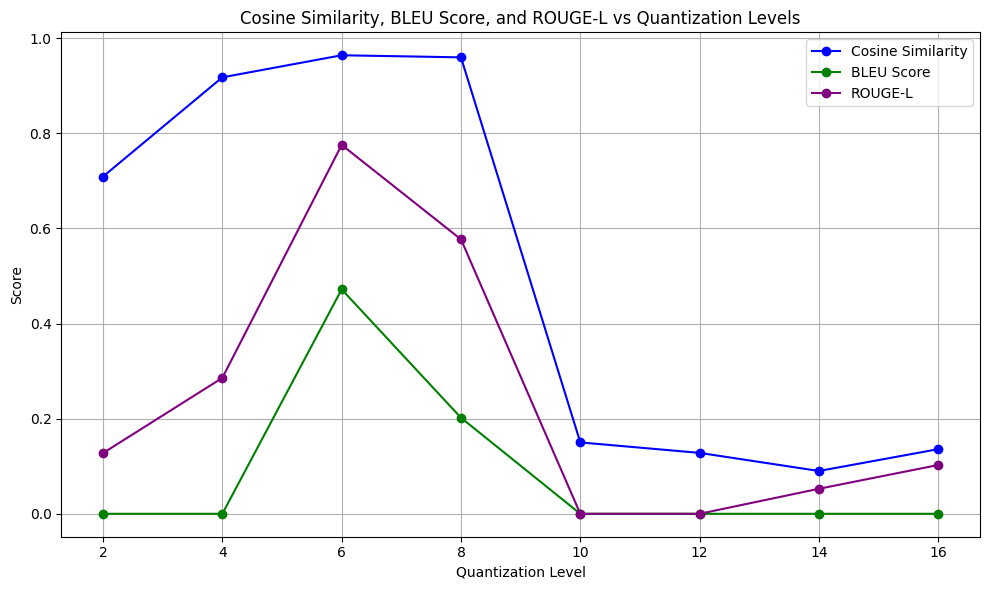

In [ ]:
bit_levels = [2, 4, 6, 8, 10, 12, 14, 16]

# Create a plot
plt.figure(figsize=(10, 6))

# Plot Cosine Similarity
plt.plot(bit_levels, cosine_similarities, marker='o', color='b', label='Cosine Similarity')

# Plot BLEU Score
plt.plot(bit_levels, bleu_scores, marker='o', color='g', label='BLEU Score')

# Plot ROUGE-L Score
plt.plot(bit_levels, rouge_l_scores, marker='o', color='purple', label='ROUGE-L')

# Set title and labels
plt.title('Cosine Similarity, BLEU Score, and ROUGE-L vs Quantization Levels')
plt.xlabel('Quantization Level')
plt.ylabel('Score')

# Add grid and legend
plt.grid(True)
plt.legend()

# Show plot
plt.tight_layout()
plt.show()
